In [1]:
# Importação de bibliotecas

import os
import sys
import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertForMaskedLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments, BertModel
import torch
from datasets import Dataset
import plotly.express as px
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import json
import seaborn as sns

c:\Users\csouza\AppData\Local\pypoetry\Cache\virtualenvs\academic-fingerprint-4AictD0y-py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Definicao da raiz do projeto

PROJECT_ROOT = 'G:/Csouza/nlp/topic_modeling'

os.chdir(PROJECT_ROOT)

sys.path.insert(0, PROJECT_ROOT)

In [3]:
def extract(extract_path, file_name='all_process.xlsx', sheet_name='Sheet1'):
    return pd.read_excel(f'{extract_path}/{file_name}', sheet_name=sheet_name)

In [4]:
data_path = os.path.join(PROJECT_ROOT, 'data', 'internal', 'fapesp_projects')

full_data = extract(data_path)

variables = {
'N. Processo_B.V': 'n_processo',
'Data de Início': 'data',
'Título (Português)': 'titulo',
'Grande Área do Conhecimento': 'grande_area',
'Área do Conhecimento': 'area',
'Subárea do Conhecimento': 'subarea',
'Palavras-Chave do Processo': 'palavras_chave',
'Assuntos': 'assuntos',
'Resumo (Português)': 'resumo'}

full_data = full_data.rename(columns=variables)

# Selecionar colunas específicas
full_data = full_data[list(variables.values())]

# Filtrar linhas com base em condições
full_data = full_data[
    full_data['n_processo'].notnull() &
    full_data['resumo'].notnull() &
    (full_data['resumo'] != '')
]

# Adicionar novas colunas com base em transformações de colunas existentes
full_data['data'] = pd.to_datetime(full_data['data'], format='%m-%d-%y', errors='coerce')
full_data['ano'] = full_data['data'].dt.year
full_data['mes'] = full_data['data'].dt.month

# Excluir a coluna 'data'
full_data = full_data.drop(columns=['data'])

In [5]:
data_train_test = full_data[full_data['assuntos'].notnull() & (full_data['area'] == 'Medicina')]
data_train_test.shape

(17342, 10)

In [6]:
def get_spacy_model(model='pt_core_news_sm'):
    """
    Baixa o modelo de linguagem spaCy se não estiver presente.
    """
    try:
        nlp = spacy.load(model)
    except OSError:
        from spacy.cli import download
        download(model)
        nlp = spacy.load(model)
    return nlp

# Carregar o modelo de linguagem em português do spaCy
nlp = get_spacy_model('pt_core_news_sm')

def clean_text(text):
    if not isinstance(text, str):
        raise ValueError("O argumento 'text' deve ser uma string.")
    
    # Converter o texto para minúsculas
    text = text.lower()
    
    # Processar o texto inteiro de uma vez
    doc = nlp(text)
    
    # Lematizar os tokens (sem remover as stop words)
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_space]
    
    # Unir tok  ens lematizados em uma string
    cleaned_text = ' '.join(lemmatized_tokens)
    
    return cleaned_text

# Carregar os dados
data = data_train_test

data['titulo'] = data['titulo'].astype(str)
data['palavras_chave'] = data['palavras_chave'].astype(str)

# Aplicar a limpeza de texto sem remover stop words
data['cleaned_text'] = data['resumo'].apply(clean_text)
data['cleaned_text'] += ' ' + data['titulo'].apply(clean_text) + ' ' + data['palavras_chave'].apply(clean_text)

C:\Users\csouza\AppData\Local\Temp\ipykernel_17844\2825361630.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['titulo'] = data['titulo'].astype(str)
C:\Users\csouza\AppData\Local\Temp\ipykernel_17844\2825361630.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['palavras_chave'] = data['palavras_chave'].astype(str)
C:\Users\csouza\AppData\Local\Temp\ipykernel_17844\2825361630.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [7]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
bert_model = BertForMaskedLM.from_pretrained('neuralmind/bert-base-portuguese-cased')

# Função de tokenização para MLM
def tokenize_function(examples):
    return tokenizer(examples['cleaned_text'], padding="max_length", truncation=True, max_length=512)

dataset = Dataset.from_pandas(data)
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Dividir em conjunto de treino e teste
train_test_split = tokenized_datasets.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

# Data collator para MLM (vai automaticamente mascarar tokens)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Map: 100%|██████████| 17342/17342 [00:53<00:00, 322.71 examples/s]


In [8]:
data['word_count'] = data['cleaned_text'].apply(lambda x: len(x.split()))
fig = px.histogram(data, x='word_count', nbins=30, title='Distribuição da Contagem de Palavras por Documento')
fig.show()

C:\Users\csouza\AppData\Local\Temp\ipykernel_17844\3917398892.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['word_count'] = data['cleaned_text'].apply(lambda x: len(x.split()))


In [9]:
# Definir as stop words em português usando spaCy
stop_words = nlp.Defaults.stop_words
additional_stop_words = ['ser', 'de', 'se', 'o', 'para', 'em', 'além', 'este', 'esse', 'ao', 'do', 'pelo', 'por', 'au']
stop_words |= set(additional_stop_words)
stop_words = {word.lower() for word in stop_words}

In [10]:
all_words = ' '.join(data['cleaned_text']).split()
all_words = [word for word in all_words if word not in stop_words]

word_freq = Counter(all_words)
common_words = word_freq.most_common(10)

words, counts = zip(*common_words)
word_freq_df = pd.DataFrame({'Palavra': words, 'Frequência': counts})

fig = px.bar(word_freq_df, x='Frequência', y='Palavra', orientation='h', title='Top 10 Palavras Mais Frequentes')
fig.show()

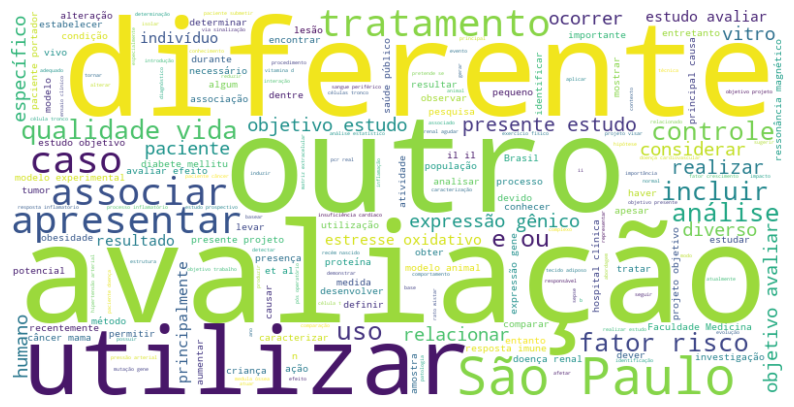

In [11]:
text = ' '.join(data['cleaned_text']).split()
text = [word for word in all_words if word not in stop_words]

text = ' '.join(text)

wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

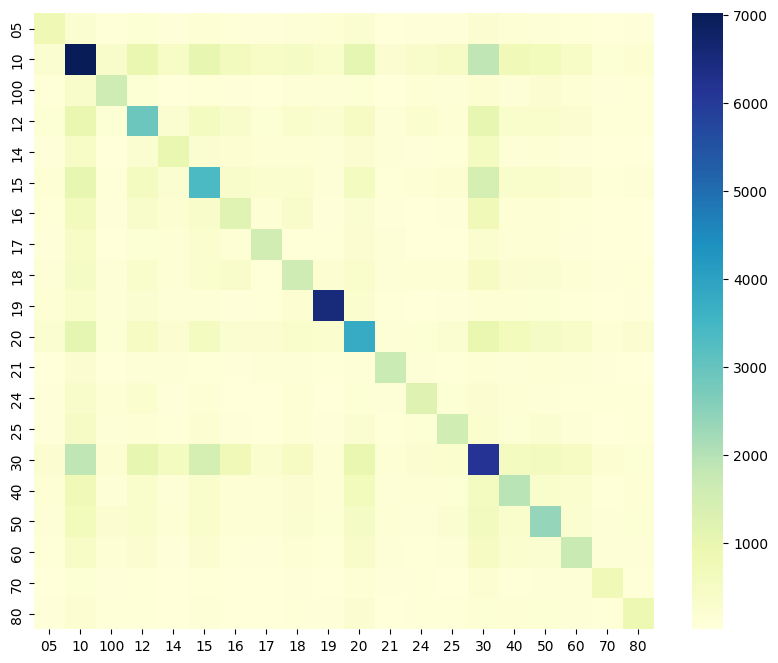

In [12]:
# Criar a matriz de coocorrência com um limite de termos
vectorizer = CountVectorizer(max_features=1000, min_df=5, max_df=0.8)
X = vectorizer.fit_transform(data['cleaned_text'])

# Obter os nomes das palavras
terms = vectorizer.get_feature_names_out()

# Calcular a matriz de coocorrência
cooc_matrix = (X.T * X).tocoo()

# Converter para DataFrame para melhor visualização
cooc_df = pd.DataFrame.sparse.from_spmatrix(cooc_matrix, index=terms, columns=terms)

# Filtrar para os termos mais frequentes
filtered_cooc_df = cooc_df.loc[terms[:20], terms[:20]]

# Visualizar a matriz de coocorrência
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_cooc_df, cmap="YlGnBu")
plt.show()

In [13]:
def train_model(model, tokenizer, train_dataset, test_dataset, data_collator, model_path, tokenizer_path, output_dir, overwrite_output_dir=True, save_steps=10_000, save_total_limit=2, prediction_loss_only=True, num_train_epochs=3, per_device_train_batch_size=8):    
    
    os.makedirs(model_path, exist_ok=True)
    os.makedirs(tokenizer_path, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=overwrite_output_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        save_steps=save_steps,
        save_total_limit=save_total_limit,
        prediction_loss_only=prediction_loss_only,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
    )

    # Treinar o modelo
    trainer.train()

    # Salvar o modelo e o tokenizer
    if model_path:
        trainer.save_model(model_path)
    
    if tokenizer_path:
        tokenizer.save_pretrained(tokenizer_path)
    
    return trainer

def evaluate_model(trainer, test_dataset):
    eval_results = trainer.evaluate(eval_dataset=test_dataset)
    loss = eval_results['eval_loss']
    perplexity = np.exp(loss)
    
    metrics = {
        'loss': loss,
        'perplexity': perplexity
    }
    
    return metrics

def extract_embeddings(texts, model, tokenizer, max_length=512, batch_size=8):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    all_embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1)
        all_embeddings.append(batch_embeddings.cpu())
    
    all_embeddings = torch.cat(all_embeddings, dim=0)
    return all_embeddings

def save_embeddings(embeddings, embeddings_path):
    np.save(embeddings_path, embeddings)
    
def load_embeddings(embeddings_path):
    if os.path.exists(embeddings_path):
        return np.load(embeddings_path)
    else:
        raise FileNotFoundError(f'Embeddings file not found at {embeddings_path}')

In [14]:
model_path = os.path.join(PROJECT_ROOT, 'models')
tokenizer_path = os.path.join(PROJECT_ROOT, 'tokenizers')
results_path = os.path.join(model_path, 'results')

embed_full_path = os.path.isfile(os.path.join(model_path, 'bertimbal_embeddings.npy'))
tokzr_full_path = os.path.isfile(os.path.join(tokenizer_path, 'vocab.txt'))

if not embed_full_path or not tokzr_full_path:
    trainer = train_model(
        model=bert_model,
        tokenizer=tokenizer,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        data_collator=data_collator,
        model_path=model_path,
        tokenizer_path=tokenizer_path,
        output_dir=results_path
    )

    metrics = evaluate_model(trainer, test_dataset)
    print("Metrics:", metrics)

 10%|▉         | 500/5205 [1:28:06<13:59:56, 10.71s/it]

{'loss': 1.7935, 'grad_norm': 5.7437286376953125, 'learning_rate': 4.5196926032660905e-05, 'epoch': 0.29}


 19%|█▉        | 1000/5205 [2:57:42<12:04:48, 10.34s/it]

{'loss': 1.548, 'grad_norm': 5.585672855377197, 'learning_rate': 4.039385206532181e-05, 'epoch': 0.58}


 29%|██▉       | 1500/5205 [4:26:52<11:06:53, 10.80s/it]

{'loss': 1.4646, 'grad_norm': 5.010249137878418, 'learning_rate': 3.5590778097982716e-05, 'epoch': 0.86}


 38%|███▊      | 2000/5205 [5:55:32<9:17:41, 10.44s/it] 

{'loss': 1.3798, 'grad_norm': 4.8309736251831055, 'learning_rate': 3.078770413064361e-05, 'epoch': 1.15}


 48%|████▊     | 2500/5205 [7:24:51<7:58:02, 10.60s/it] 

{'loss': 1.3502, 'grad_norm': 6.3009490966796875, 'learning_rate': 2.5984630163304517e-05, 'epoch': 1.44}


 58%|█████▊    | 3000/5205 [8:54:26<6:28:04, 10.56s/it]

{'loss': 1.3171, 'grad_norm': 6.080270767211914, 'learning_rate': 2.118155619596542e-05, 'epoch': 1.73}


 67%|██████▋   | 3500/5205 [10:23:29<5:06:15, 10.78s/it]

{'loss': 1.2889, 'grad_norm': 4.351497173309326, 'learning_rate': 1.6378482228626322e-05, 'epoch': 2.02}


 77%|███████▋  | 4000/5205 [11:52:43<3:37:26, 10.83s/it]

{'loss': 1.2525, 'grad_norm': 4.637373447418213, 'learning_rate': 1.1575408261287224e-05, 'epoch': 2.31}


 86%|████████▋ | 4500/5205 [13:22:17<2:04:27, 10.59s/it]

{'loss': 1.2475, 'grad_norm': 5.104547023773193, 'learning_rate': 6.7723342939481265e-06, 'epoch': 2.59}


 96%|█████████▌| 5000/5205 [14:49:59<35:23, 10.36s/it]  

{'loss': 1.2312, 'grad_norm': 4.922740936279297, 'learning_rate': 1.96926032660903e-06, 'epoch': 2.88}


100%|██████████| 5205/5205 [15:25:31<00:00, 10.67s/it]


{'train_runtime': 55531.4863, 'train_samples_per_second': 0.749, 'train_steps_per_second': 0.094, 'train_loss': 1.38147903427725, 'epoch': 3.0}


100%|██████████| 434/434 [29:12<00:00,  4.04s/it]

Metrics: {'loss': 1.1701853275299072, 'perplexity': 3.222589817800748}


In [15]:
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
bert_model = BertModel.from_pretrained(model_path)

Some weights of BertModel were not initialized from the model checkpoint at G:/Csouza/nlp/topic_modeling\models and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
embeddings_name = f'{model_path}/bertimbal_embeddings_09_09_24.npy'
if not os.path.exists(embeddings_name):
    text_embeddings = train_dataset['cleaned_text']
    embeddings = extract_embeddings(text_embeddings, bert_model, tokenizer)
    save_embeddings(embeddings, embeddings_name)

In [17]:
vocab_path = os.path.join(PROJECT_ROOT, 'data', 'processed', 'usp_controlled_vocabulary')
vocab_name = 'vocabulario_usp_hierarchy.json'

# Carregar o vocabulário controlado da USP
with open(f'{vocab_path}/{vocab_name}', 'r', encoding='utf-8') as file:
    vocab_data = json.load(file)

# Função para extrair termos de forma hierárquica
def extract_terms(vocab_data, terms_list=None):
    if terms_list is None:
        terms_list = []

    for item in vocab_data:
        term = item['string']
        terms_list.append(term)
        if 'subterms' in item and item['subterms']:
            extract_terms(item['subterms'], terms_list)

    return terms_list

# Extrair todos os termos do vocabulário controlado
all_terms = extract_terms(vocab_data)

In [31]:
# Função para filtrar palavras de cada linha de acordo com a lista fornecida e contar os matchs
def filter_words_in_list(df, col_name, word_list, no_match_value=None):
    # Define uma função para ser aplicada em cada linha da coluna
    def match_words(row):
        words_in_row = row.split(":")  # Separa as palavras por ":"
        matched_words = [word for word in words_in_row if word in word_list]  # Filtra as palavras que estão na lista
        
        if matched_words:  # Se houver correspondências, retorna as palavras
            return ":".join(matched_words), len(matched_words)  # Retorna a string e o número de correspondências
        else:
            return no_match_value, 0  # Se não houver correspondências, retorna o valor especificado e 0 matchs

    # Aplica a função em cada linha da coluna original e cria duas colunas com o resultado
    df[['filtered_words', 'match_count']] = df[col_name].apply(lambda row: pd.Series(match_words(row)))
    return df

In [32]:
filtered_data = filter_words_in_list(data, 'assuntos', all_terms)

C:\Users\csouza\AppData\Local\Temp\ipykernel_17844\3224397802.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\csouza\AppData\Local\Temp\ipykernel_17844\3224397802.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
def get_embedding(text, tokenizer, model, max_length=512):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_length)
    outputs = model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embedding.squeeze()

def compute_similarity(embedding1, embedding2):
    return cosine_similarity(embedding1.reshape(1, -1), embedding2.reshape(1, -1))[0, 0]

# Obtenha os embeddings das palavras do dicionário
dictionary_embeddings = np.array([get_embedding(word, tokenizer, bert_model) for word in all_terms])

# Função para encontrar as 10 palavras mais semelhantes do dicionário para um texto
def find_top_similar_words(text_embedding, dictionary_embeddings, dictionary_words, top_n=10):
    # Calcular a similaridade de cosseno para todos os embeddings em um único passo
    similarities = cosine_similarity(text_embedding.reshape(1, -1), dictionary_embeddings).flatten()
    
    # Obter os índices das top_n palavras mais semelhantes
    top_indices = np.argsort(similarities)[::-1][:top_n]
    
    # Retornar as palavras mais semelhantes
    top_words = [dictionary_words[i] for i in top_indices]
    return top_words

# Aplicar aos textos
top_words_per_text = []

for text in data['cleaned_text']:
    # Obter o embedding do texto
    text_embedding = get_embedding(text, tokenizer, bert_model)
    
    # Encontrar as 10 palavras mais semelhantes do dicionário para o texto
    top_words = find_top_similar_words(text_embedding, dictionary_embeddings, all_terms)
    
    top_words_per_text.append(top_words)

In [27]:
test = filtered_data[filtered_data["filtered_words"].notnull()]

In [34]:
test.head()

,n_processo,titulo,grande_area,area,subarea,palavras_chave,assuntos,resumo,ano,mes,cleaned_text,word_count,top_words_per_text,filtered_words,match_count
2872,94/05619-6,Transmissão do HIV entre estudantes da Univers...,Ciências da Saúde,Medicina,NaN,nan,Transmissão de doença infecciosa:HIV:AIDS:Comp...,A população de estudantes universitários é com...,1995,6,o população de estudante universitário ser com...,259,[ESCALA DE QUALIDADE DE VIDA DE CLIENTES DE SE...,HIV,1.0
3836,94/04030-9,Alteracoes moleculares na deficiencia de glico...,Ciências da Saúde,Medicina,Clínica Médica,"ANEMIA HEMOLITICA, DEFICIENCIA DE G-6-PD, DNA",Anemia hemolítica:DNA,A deficiência de G6PD é uma entidade clínica r...,1995,3,o deficiência de g6pd ser um entidade clínico ...,174,"[ANÁLISE DE SEQUÊNCIA DE DNA, INFECÇÕES POR HT...",DNA,1.0
5658,94/03113-8,Usuários de drogas HIV positivos: relação entr...,Ciências da Saúde,Medicina,Psiquiatria,"ADESAO AO TRATAMENTO, COCAINA, COMPORTAMENTO D...",Cooperação e adesão ao tratamento:Comportament...,O número de usuários de drogas no Brasil que s...,1994,10,o número de usuário de droga em o Brasil que s...,250,[ESCALA DE QUALIDADE DE VIDA DE CLIENTES DE SE...,HIV,1.0
6836,94/00658-3,Fibromatose musculo-aponeurotica - tumor desmo...,Ciências da Saúde,Medicina,Anatomia Patológica e Patologia Clínica,"CITOMETRIA DE FLUXO, DNA, FIBROMATOSE PROFUNDA...",Citometria de fluxo:DNA:Histologia,São estudados 100 casos de fibromatose músculo...,1994,7,ser estudar 100 caso de fibromatose músculo-ap...,106,[QUESTIONÁRIO DE SINTOMAS DE TRANSTORNO DISFÓR...,DNA,1.0
12153,92/01230-1,Quantificação do RNA do Vírus da Hepatite C (H...,Ciências da Saúde,Medicina,Clínica Médica,"ENZIMA IMUNO ENSAIO, HEPATITE CRONICA C, INTER...",Hepatite C crônica:Vírus da hepatite C:Ribavir...,A terapia da hepatite não-A não-B © com drogas...,1992,8,o terapia de o hepatite não-a não-b © com drog...,145,"[INFECÇÕES POR HTLV-I, INFECÇÕES POR HTLV-II, ...",HIV,1.0
